<a id='top'></a>
# Using Teranet data for Parking Lot Taxation research

**This notebook presents a sample of how real estate sales data from the Teranet dataset could be used for the research of Parking Lot Taxation.**

This notebook aims to demonstrate how point sales data from Teranet dataset could be combined with data on parking lots and provide spatially-related context on the value of property transactions occuring in the immediate vicinity of a given parking lot in Toronto (or other Ontario cities) in a given period of time (1980-2017).

The proposed logic used in this example:

* Load the shapefile containing the subset of Teranet dataset that contains all transactions recorded in Toronto (spatial information is recorded as coordinates of each transaction)

* Load the dataset of parking (spatial information is recorded as address of each parking lot)

* For this example, the first parking lot (first row) of the parking lot dataset is used to illustrate the potential for connection with the real estate sales data:

    * First row from the parking lot dataset is taken
    
    * Address information for the record is manually converted to GIS coordinates (taken from Google maps)
    
    * A 1,000-m buffer is drawn around the parking lot
    
    * All real estate transactions from the buffer that occured in 2017 are selected from the Teranet dataset, price distribution is displayed. Mean and median price are displayed monthly
    
    * 5-year subset of sales points that fall within the 1,000-m buffer is taken from real estate sales dataset, mean and median price are displayed per annum
    
* The proposed workflow can easily be replicated for any number of parking lots and different time criteria, as long as coordinates of the parking lots can be provided. Size of buffer can be adjusted. Additional attributes can be added to the analysis.

    * The coordinate pair used in this example was entered by hand
    
    * Geocoding can be used to convert parking lot addresses into GIS coordinates.

# 1. Import libraries

Back to the [top](#top)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import contextily as ctx
import geopy
import os
from time import time
from shapely.geometry import Point

## Load Teranet data, join GTA land use codes
### Load GTA land use codes

In [2]:
teranet_path = '../../data/teranet/'
landuse_code_path = teranet_path + 'ParcelLandUse/GTA/'
os.listdir(landuse_code_path)

['GTA_land_use_code.txt',
 'GTAparcel16LU12.shx',
 'with_epoi',
 'GTAparcel16LU12.prj',
 'gta_land_use_code.csv',
 'GTAparcel16LU12.cpg',
 'GTAparcel16LU12.shp',
 'GTAparcel16LU12.dbf']

In [3]:
land_use_codes = pd.read_csv(landuse_code_path + 'gta_land_use_code.csv')
land_use_codes.head()

,landuse,code
0,0,Uncoded
1,1,Single Detached House
2,2,Commercial/Shopping
3,3,Industrial/Employment Lands
4,4,Government/Institutional


### Load Teranet, join GTA land use, generate GeoDataFrame

In [4]:
os.listdir(teranet_path)

['1.1_Teranet_DA.csv',
 '1.3_Teranet_DA_TAZ_PG_FSA.csv',
 '2_Teranet_consistent.csv',
 'parcel16_epoi13.csv',
 '1.2_Teranet_DA_TAZ.csv',
 '1.4_Teranet_DA_TAZ_FSA_LU_LUDMTI.csv',
 '1.4_Teranet_DA_TAZ_FSA_LU.csv',
 '.ipynb_checkpoints',
 'ParcelLandUse.zip',
 'ParcelLandUse',
 'HHSaleHistory.csv',
 '3_Teranet_nonan_new_cols.csv',
 'GTAjoinedLanduseSales']

In [5]:
# load DataFrame with Teranet records
t = time()
teranet_df = pd.read_csv(teranet_path + '3_Teranet_nonan_new_cols.csv',
                         parse_dates=['registration_date'])
elapsed = time() - t
print("----- DataFrame loaded"
      "\nin {0:.2f} seconds".format(elapsed) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(teranet_df.shape[0], teranet_df.shape[1]) + 
      "\n-- Column names:\n", teranet_df.columns)

# join GTA land use codes
teranet_df = pd.merge(teranet_df, land_use_codes, how='left',
                      left_on='landuse', right_on='landuse')
print("\n----- GTA land use codes were joined to the DataFrame.")

# combine values in columns 'x' and 'y' into a POINT geometry object
t = time()
geometry = [Point(xy) for xy in zip(teranet_df['x'], teranet_df['y'])]
# generate a new GeoDataFrame by adding point geometry to data frame 'teranet_sales_data'
teranet_gdf = gpd.GeoDataFrame(teranet_df, geometry=geometry)
elapsed = time() - t
print("\n----- Geometry generated from 'X' and 'Y' pairs, GeoDataFrame created!"
      "\nin {0:.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(teranet_gdf.shape[0], teranet_gdf.shape[1]) + 
      "\n-- Column names:\n", teranet_gdf.columns)

# add CRS for WGS84 (lat-long) to GeoDataFrame with Teranet records
teranet_gdf.crs = {'proj': 'latlong', 
                   'ellps': 'WGS84', 
                   'datum': 'WGS84', 
                   'no_defs': True}
print("\n----- CRS dictionary for WGS84 added to geo data frame 'teranet_gdf'!")

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (6,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


----- DataFrame loaded
in 44.60 seconds
with 5,188,513 rows
and 54 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction', 'municipality',
       'street_number', 'x', 'y', 'dauid', 'csduid', 'csdname', 'taz_o', 'fsa',
       'pca_id', 'postal_code_dmti', 'pin_lu', 'landuse', 'prop_code',
       'dmti_lu', 'street_name_raw', 'year', 'year_month', 'year3',
       'census_year', 'census2001_year', 'tts_year', 'tts1991_year', 'xy',
       'pin_total_sales', 'xy_total_sales', 'pin_prev_sales', 'xy_prev_sales',
       'pin_price_cum_sum', 'xy_price_cum_sum', 'pin_price_pct_change',
       'xy_price_pct_change', 'price_da_pct_change',
       'pin_years_since_last_sale', 'xy_years_since_last_sale',
       'da_days_since_last_sale', 'da_years_since_last_sale',
       'pin_sale_next_6m', 'pin_sale_next_1y', 'pin_sale_next_3y',
       'xy_sale_nex

## Load the parking lot data

Presenting an example for one paring lot with coordinates entered by hand. The same process can be repeated automatically for the full parking lot dataset by geocoding addresses into parking lot coordinates.

#### Manually find the coordinates for the address of the first parking lot

Taken from [Google maps](https://www.google.ca/maps/place/480+Bloor+St+W,+Toronto,+ON+M5S+1X8/@43.6645464,-79.4097829,176a,35y,39.45t/data=!3m1!1e3!4m5!3m4!1s0x882b3493e419bf3b:0xdcd9d1cd31f6b92c!8m2!3d43.665594!4d-79.4095102?hl=en), can be geocoded automatically for all parking points instead.




**480 Bloor St.:** -79.409513, 43.665595


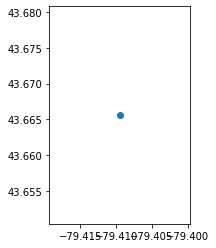

In [7]:
parking_point = pd.DataFrame({'parking_lot': 1}, index=range(1))
parking_point_geom = Point([-79.409513, 43.665595])     # using Point from shapely
parking_point['coordinates'] = parking_point_geom
parking_point_gdf = gpd.GeoDataFrame(parking_point, geometry='coordinates')
parking_point_gdf.crs = {'init': 'epsg:4326', 'no_defs': True}
parking_point_gdf.plot();

## Parking lot with a 1'000m buffer

### Create a GeoDataFrame with the 1,000m buffer around the first parking lot

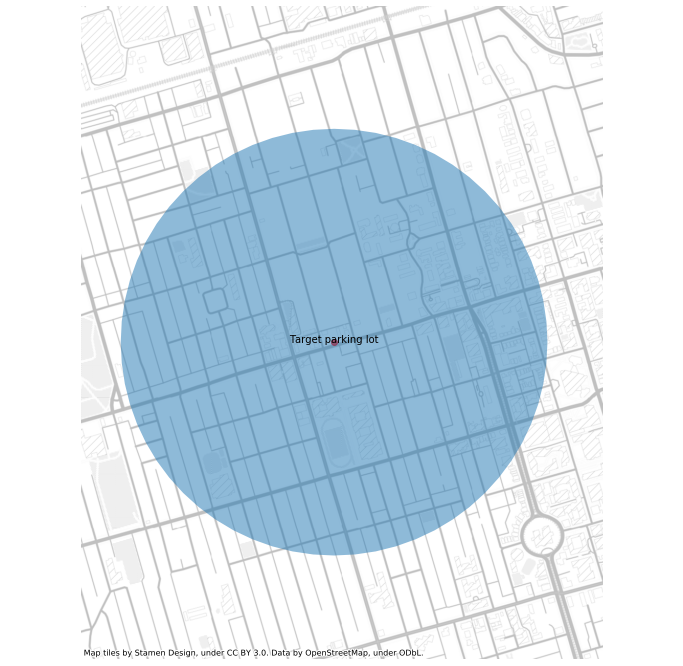

In [33]:
buffer_size = 1000     # size of buffer to draw around the parking lot, in meters

buffer_gdf = gpd.GeoDataFrame(parking_point_gdf.to_crs(epsg=3857).buffer(buffer_size))
buffer_gdf = buffer_gdf.rename(columns={0:'geometry'}).set_geometry('geometry')
buffer_gdf.crs = {'init': 'epsg:3857'}
buffer_gdf = buffer_gdf.to_crs(epsg=4326)

f, ax = plt.subplots(1, figsize=(12, 12))
parking_point_gdf.to_crs(epsg=3857).plot(ax=ax, color='red', alpha=0.8)
buffer_gdf.to_crs(epsg=3857).plot(ax=ax, alpha=0.5)
ctx.add_basemap(ax, url=ctx.sources.ST_TONER_BACKGROUND,
                alpha=0.25)
ax.text(parking_point_gdf.to_crs(epsg=3857).loc[0, 'coordinates'].x,
        parking_point_gdf.to_crs(epsg=3857).loc[0, 'coordinates'].y,
        "Target parking lot", fontsize=10, ha='center')
ax.set_axis_off()
plt.axis('equal')
plt.show()

### Take a subset of Teranet records for 2016

In [9]:
year = 2016
csd_name = 'Toronto'
mask1 = teranet_gdf['year'] == year
mask2 = teranet_gdf['csdname'] == csd_name
s = teranet_gdf[mask1 & mask2]
print("{0:,} Teranet records from {1} in {2}.".format(len(s), csd_name, year))

112,982 Teranet records from Toronto in 2016.


### Plot all transactions and the parking lot with a 1,000m buffer

Took 30.56 seconds (0.51 minutes) to plot


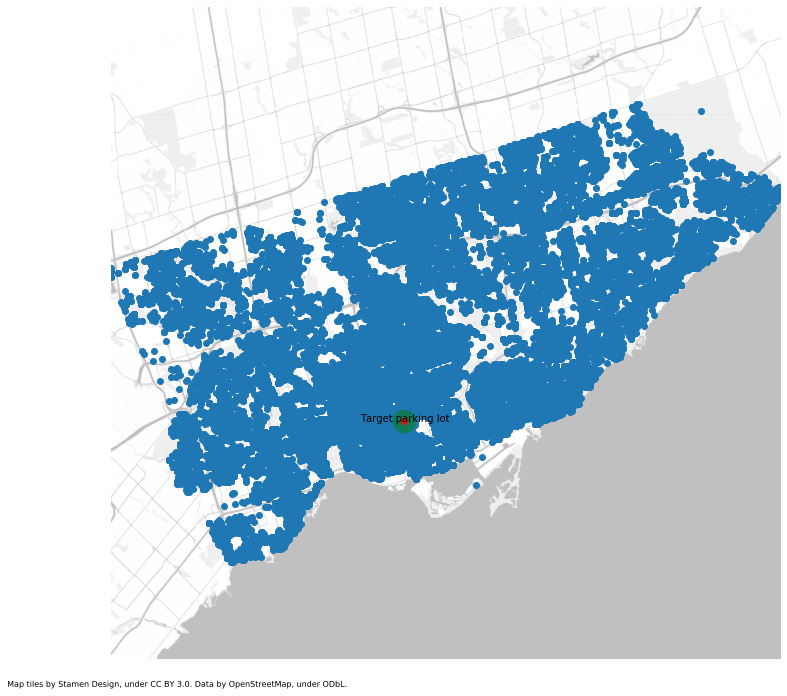

In [31]:
t = time()
f, ax = plt.subplots(1, figsize=(12, 12))
s.to_crs(epsg=3857).plot(ax=ax)
buffer_gdf.to_crs(epsg=3857).plot(ax=ax, color='green', alpha=0.5)
parking_point_gdf.to_crs(epsg=3857).plot(ax=ax, color='red', alpha=0.8)
ctx.add_basemap(ax, url=ctx.sources.ST_TONER_BACKGROUND,
                alpha=0.25)
ax.text(parking_point_gdf.to_crs(epsg=3857).loc[0, 'coordinates'].x,
        parking_point_gdf.to_crs(epsg=3857).loc[0, 'coordinates'].y,
        "Target parking lot", fontsize=10, ha='center')
ax.set_axis_off()
plt.axis('equal')
minX, minY, maxX, maxY = s.to_crs(epsg=3857).total_bounds
ax.set_xlim(minX, maxX)
ax.set_ylim(minY, maxY)
elapsed = time() - t
print("Took {0:,.2f} seconds ({1:,.2f} minutes) to plot".format(elapsed, elapsed / 60))
plt.show()

## Transactions within 1,000m from the parking lot

#### Validating CRS

In [11]:
teranet_gdf.crs

{'proj': 'latlong', 'ellps': 'WGS84', 'datum': 'WGS84', 'no_defs': True}

In [12]:
buffer_gdf.crs

{'init': 'epsg:4326', 'no_defs': True}

#### Perform the spatial join
>Note: EPSG:4326 and WGS 84 represent the [same projection](https://spatialreference.org/ref/epsg/wgs-84/).

In [13]:
t = time()
parking_sales_join = gpd.sjoin(s, buffer_gdf, how='inner', op='within')
elapsed = time() - t
print('{0:,} transactions occured in {1} within the boundary of the buffer.'.
     format(len(parking_sales_join), year))
print("Saved in a new geodataframe 'parking_sales_join'. Took {0:,.2f} seconds ({1:,.2f} minutes)."
      .format(elapsed, elapsed / 60))

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/geopandas/tools/sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


208 transactions occured in 2016 within the boundary of the buffer.
Saved in a new geodataframe 'parking_sales_join'. Took 4.68 seconds (0.08 minutes).


#### Plot the subset from the join
Records with missing `code` values are dropped.

Took 2.13 seconds (0.04 minutes) to plot


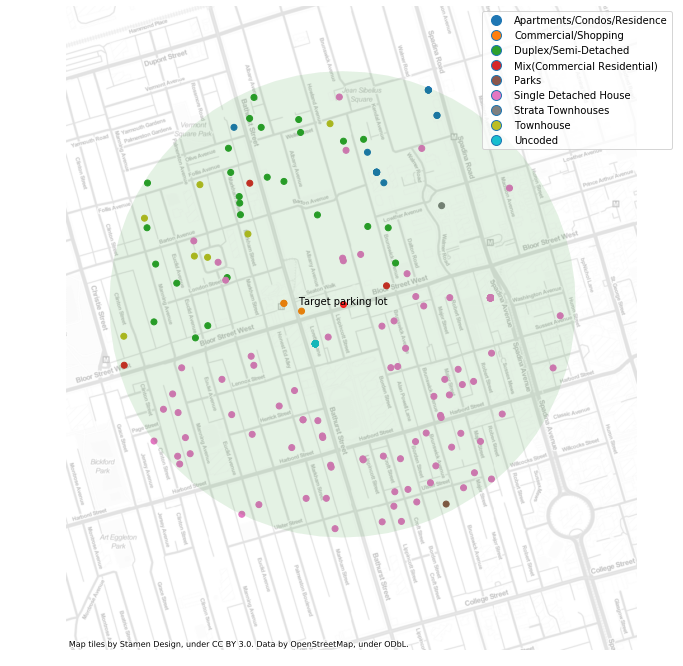

In [32]:
t = time()
f, ax = plt.subplots(1, figsize=(12, 12))
parking_sales_join.dropna(subset=['code']).to_crs(epsg=3857)\
    .plot(ax=ax, column='code', categorical=True, legend=True)
buffer_gdf.to_crs(epsg=3857).plot(ax=ax, color='green', alpha=0.1)
ax.text(parking_point_gdf.to_crs(epsg=3857).loc[0, 'coordinates'].x,
        parking_point_gdf.to_crs(epsg=3857).loc[0, 'coordinates'].y,
        "Target parking lot", fontsize=10, ha='center')
parking_point_gdf.to_crs(epsg=3857).plot(ax=ax, color='red', alpha=0.8)
ctx.add_basemap(ax, url=ctx.sources.ST_TONER_LITE,
                alpha=0.25)
ax.set_axis_off()
plt.axis('equal')
minX, minY, maxX, maxY = parking_sales_join.to_crs(epsg=3857).total_bounds
ax.set_xlim(minX - 500, maxX + 500)
ax.set_ylim(minY - 500, maxY + 300)
elapsed = time() - t
print("Took {0:,.2f} seconds ({1:,.2f} minutes) to plot".format(elapsed, elapsed / 60))
plt.savefig('results/maps/teranet_parking.png', dpi=400)

#### Mean and median price

In [45]:
print("Mean price of the {0} transactions that occured within {1} meters of the parking lot in {2}:\n{3:,}$"
     .format(len(parking_sales_join),
            buffer_size,
            year,
            round(parking_sales_join['price_2016'].mean(), 2)))
print("Median price of the {0} transactions that occured within {1} meters of the parking lot in {2}:\n{3:,}$"
     .format(len(parking_sales_join),
            buffer_size,
            year,
            round(parking_sales_join['price_2016'].median(), 2)))

Mean price of the 208 transactions that occured within 1000 meters of the parking lot in 2016:
1,233,034.03$
Median price of the 208 transactions that occured within 1000 meters of the parking lot in 2016:
1,032,500.0$


#### Context from price distribution

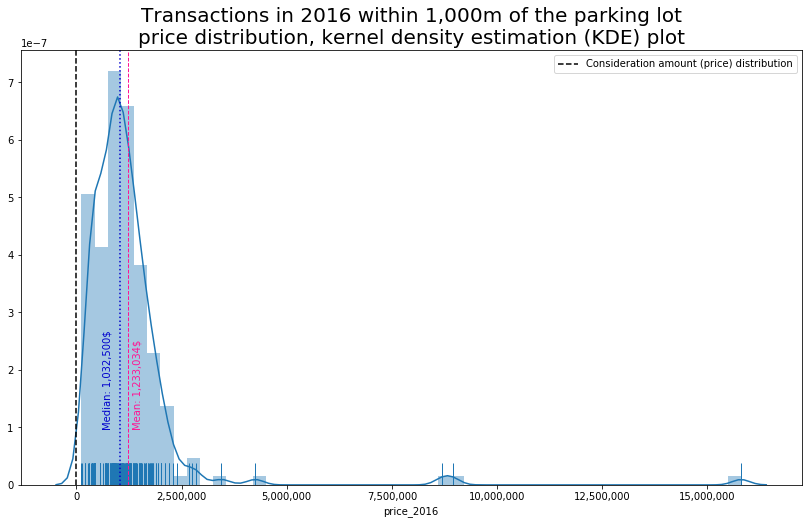

In [80]:
# generate figure and axes
f, ax = plt.subplots(1, figsize=(14, 8))

# plot distribution of price in the subset
sns.distplot(parking_sales_join['price_2016'], kde=True, rug=True, ax=ax)

# calculate mean and median for the subset
sales_mean = int(parking_sales_join['price_2016'].mean())
sales_median = int(parking_sales_join['price_2016'].median())

# set axis parameters
ax.axvline(0, linestyle='--', color='black')
ax.axvline(sales_mean, linestyle='--', linewidth=1, color='deeppink')
ax.axvline(sales_median, linestyle=':', color='mediumblue')
ax.text(sales_mean * 1.08, 0.00000010, 'Mean: {:,}$'.format(sales_mean), color='deeppink', rotation=90)
ax.text(sales_median * 0.6, 0.00000010, 'Median: {:,}$'.format(sales_median), color='mediumblue', rotation=90)
ax.legend(['Consideration amount (price) distribution'])
ax.set_title("Transactions in {0} within {1:,}m of the parking lot\n"
             "price distribution, kernel density estimation (KDE) plot".format(year, buffer_size), 
             fontsize=20)
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

#### Overall mean vs mean of monthly means

There can be a discrepancy in values if mean and median are calculated from the monthly means and medians vs overall mean and median.

In [17]:
parking_sales_join['considerat'].mean()

1428093.2781456953

In [18]:
parking_sales_join['considerat'].groupby(pd.Grouper(freq="M")).mean().mean()

1405265.8709575213

#### Context from monthly means and medians

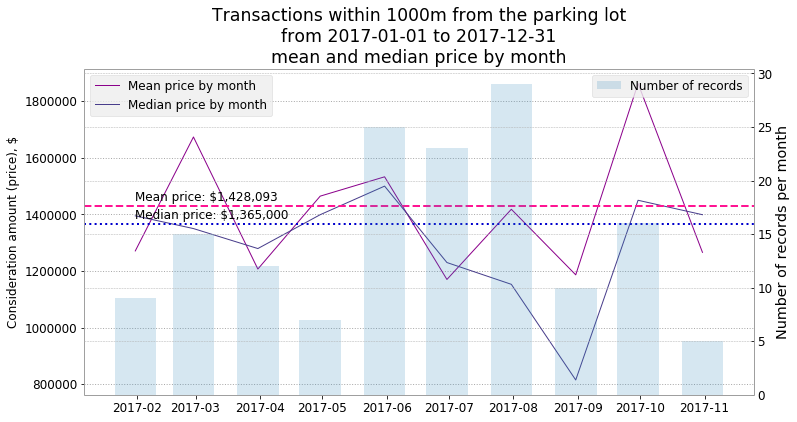

In [19]:
monthly_means = parking_sales_join['price_2016'].groupby('year'.mean()
monthly_medians = parking_sales_join['considerat'].groupby(pd.Grouper(freq="M")).median()
monthly_counts = parking_sales_join['considerat'].groupby(pd.Grouper(freq="M")).count()

f, ax1 = plt.subplots(1, figsize=(12, 6))
plt.style.use('bmh')
ax1.plot(monthly_means, linestyle='-', linewidth=1, color='darkmagenta')
ax1.plot(monthly_medians, linestyle='-', linewidth=1, color='darkslateblue')
ax1.axhline(sales_mean, linewidth=2, linestyle='--', color='deeppink')
ax1.axhline(sales_median, linewidth=2, linestyle=':', color='mediumblue')
ax1.text('2017-01-31', sales_mean + 20000, 'Mean price: ${:,}'.format(sales_mean))
ax1.text('2017-01-31', sales_median + 20000, 'Median price: ${:,}'.format(sales_median))
ax1.yaxis.grid(color='darkgray', linewidth=1, linestyle=':')
ax1.legend(['Mean price by month', 'Median price by month'])
ax1.set_title("Transactions within {0}m from the parking lot\nfrom {1} to {2}\nmean and median price by month"
            .format(
                    buffer_size,
                    start_date,
                    end_date))
ax1.set_ylabel("Consideration amount (price), $")

ax2 = ax1.twinx()
ax2.bar(monthly_counts.index, monthly_counts, label='Number of records', width=20, alpha=0.2)
ax2.set_ylabel("Number of records per month")
ax2.legend(loc='upper right')

plt.show()

## Transactions within 1,000m, 5 year history

In [20]:
start_date = '2013-01-01'
end_date = '2017-12-31'

db_sales_points_5yr_subset = db_sales_points.loc[start_date:end_date]
print("{0} total records in the subset of transactions that occured in Toronto from {1} to {2}"
      .format(
              len(db_sales_points_5yr_subset),
              start_date,
              end_date
              ))
db_sales_points_5yr_subset.head()

332002 total records in the subset of transactions that occured in Toronto from 2013-01-01 to 2017-12-31


,row_num,decade,year,lro_num,pin,considerat,postal_cod,province,unitno,street_nam,...,street_suf,street_num,x,y,index_lu,category,accuracy,index_neig,neighbourh,geometry
registrati,,,,,,,,,,,,,,,,,,,,,
2014-10-10,7222858,201,2014,80,214120219,3900000.0,M5V1X2,ON,NaN,Richmond,...,NaN,340.0,-79.392961,43.648875,146301,Residential,Within 50 metres,8,Waterfront Communities-The Island,POINT (-79.3929612490533 43.6488748977188)
2016-11-21,7925107,201,2016,80,765470217,431729.0,None,ON,NaN,Richmond Street. West,...,NaN,318.0,-79.392008,43.649050,146301,Residential,Within 50 metres,8,Waterfront Communities-The Island,POINT (-79.3920080297622 43.64904964750301)
2016-11-21,7925110,201,2016,80,765470149,323784.0,None,ON,NaN,Richmond Street,...,NaN,318.0,-79.392008,43.649050,146301,Residential,Within 50 metres,8,Waterfront Communities-The Island,POINT (-79.3920080297622 43.64904964750301)
2016-11-21,7925098,201,2016,80,765470244,547963.0,None,ON,NaN,Richmond Street West,...,NaN,318.0,-79.392008,43.649050,146301,Residential,Within 50 metres,8,Waterfront Communities-The Island,POINT (-79.3920080297622 43.64904964750301)
2016-11-21,7925113,201,2016,80,765470152,266791.0,None,ON,NaN,None,...,NaN,NaN,-79.392008,43.649050,146301,Residential,Within 50 metres,8,Waterfront Communities-The Island,POINT (-79.3920080297622 43.64904964750301)


#### Perform the spatial join

In [21]:
%%time
db_sales_points_5yr_subset.crs = {'init': 'epsg:4326', 'no_defs': True}
parking_sales_5yr_join = gpd.sjoin(db_sales_points_5yr_subset, buffer_gdf, how='inner', op='within')
print('{0} transactions occured from {1} to {2} within the boundary of the buffer.'.
     format(
             len(parking_sales_5yr_join),
             start_date,
             end_date
            ))
print("Saved in a new geodataframe 'parking_sales_5yr_join'.")

1223 transactions occured from 2013-01-01 to 2017-12-31 within the boundary of the buffer.
Saved in a new geodataframe 'parking_sales_5yr_join'.
Wall time: 16 s


#### Plot the subset from the join

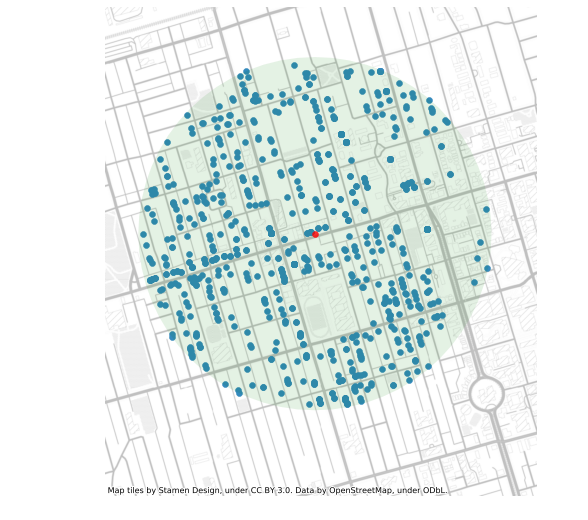

Wall time: 3.08 s


In [22]:
%%time
f, ax = plt.subplots(1, figsize=(9, 9))
parking_sales_5yr_join.to_crs(epsg=3857).plot(ax=ax)
buffer_gdf.to_crs(epsg=3857).plot(ax=ax, color='green', alpha=0.1)
parking_point_gdf.to_crs(epsg=3857).plot(ax=ax, color='red', alpha=0.8)
ctx.add_basemap(ax, url=ctx.sources.ST_TONER_BACKGROUND,
                alpha=0.25)
ax.set_axis_off()
plt.axis('equal')
minX, minY, maxX, maxY = parking_sales_join.to_crs(epsg=3857).total_bounds
ax.set_xlim(minX - 500, maxX + 500)
ax.set_ylim(minY - 500, maxY + 300)
plt.show()

In [23]:
print("Mean price of the {0} transactions that occured within {1} meters of the parking lot between {2} and {3}:\n{4:,}$"
     .format(
            len(parking_sales_5yr_join),
            buffer_size,
            start_date,
            end_date,
            round(parking_sales_5yr_join['considerat'].mean(), 2)
             ))
print("Median price of the {0} transactions that occured within {1} meters of the parking lot between {2} and {3}:\n{4:,}$"
     .format(
            len(parking_sales_5yr_join),
            buffer_size,
            start_date,
            end_date,
            round(parking_sales_5yr_join['considerat'].median(), 2)
             ))

Mean price of the 1223 transactions that occured within 1000 meters of the parking lot between 2013-01-01 and 2017-12-31:
1,901,362.02$
Median price of the 1223 transactions that occured within 1000 meters of the parking lot between 2013-01-01 and 2017-12-31:
859,900.0$


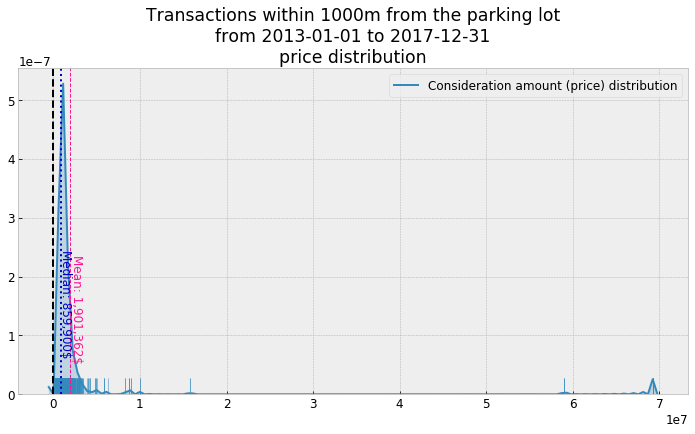

In [24]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)


sales_mean = int(parking_sales_5yr_join['considerat'].mean())
sales_median = int(parking_sales_5yr_join['considerat'].median())

f, ax = plt.subplots(1, figsize=(12,6))
ax = sns.kdeplot(parking_sales_5yr_join['considerat'], shade=True)
ax = sns.rugplot(parking_sales_5yr_join['considerat'], alpha=0.5)
ax.axvline(0, linestyle='--', color='black')
ax.axvline(sales_mean, linestyle='--', linewidth=1, color='deeppink')
ax.axvline(sales_median, linestyle=':', color='mediumblue')
ax.text(sales_mean + 20000, 0.00000022, 'Mean: {:,}$'.format(sales_mean), color='deeppink', rotation=-90)
ax.text(sales_median - 250000, 0.00000023, 'Median: {:,}$'.format(sales_median), color='mediumblue', rotation=-90)
ax.legend(['Consideration amount (price) distribution'])
ax.set_title("Transactions within {0}m from the parking lot\nfrom {1} to {2}\nprice distribution"
            .format(
                    buffer_size,
                    start_date,
                    end_date))
plt.show()

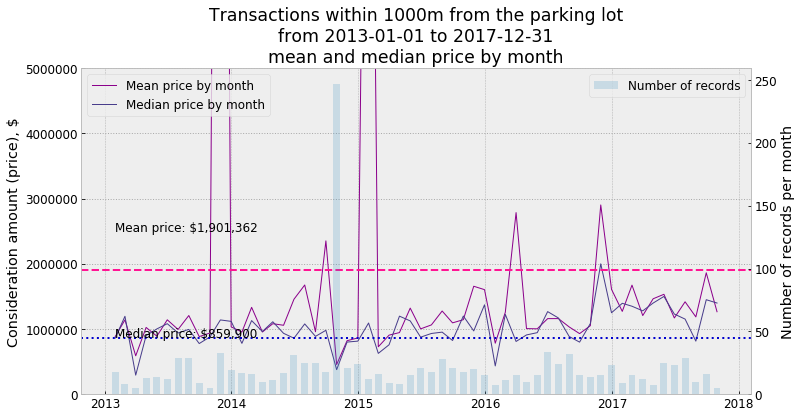

In [25]:
monthly_means = parking_sales_5yr_join['considerat'].groupby(pd.Grouper(freq="M")).mean()
monthly_medians = parking_sales_5yr_join['considerat'].groupby(pd.Grouper(freq="M")).median()
monthly_counts = parking_sales_5yr_join['considerat'].groupby(pd.Grouper(freq="M")).count()

f, ax1 = plt.subplots(1, figsize=(12, 6))
plt.style.use('bmh')
ax1.plot(monthly_means, linestyle='-', linewidth=1, color='darkmagenta')
ax1.plot(monthly_medians, linestyle='-', linewidth=1, color='darkslateblue')
ax1.axhline(sales_mean, linewidth=2, linestyle='--', color='deeppink')
ax1.axhline(sales_median, linewidth=2, linestyle=':', color='mediumblue')
ax1.text('2013-01-31', sales_mean + 600000, 'Mean price: ${:,}'.format(sales_mean))
ax1.text('2013-01-31', sales_median + 20000, 'Median price: ${:,}'.format(sales_median))
ax1.yaxis.grid(color='darkgray', linewidth=1, linestyle=':')
ax1.set_title("Transactions within {0}m from the parking lot\nfrom {1} to {2}\nmean and median price by month"
            .format(
                    buffer_size,
                    start_date,
                    end_date))
ax1.set_ylabel("Consideration amount (price), $")
ax1.set_ylim(0, 5000000)
ax1.legend(['Mean price by month', 'Median price by month'], loc='upper left')

ax2 = ax1.twinx()
ax2.bar(monthly_counts.index, monthly_counts, label='Number of records', width=20, alpha=0.2)
ax2.set_ylabel("Number of records per month")
ax2.yaxis.grid(linewidth=0)
ax2.legend(loc='upper right')

plt.show()